<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/DEV_Copy_of_NBM_4_1_Reliability_With_Obs%2BURMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INSTALL AND IMPORTS                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

!pip install boto3
!pip install pygrib
!pip install swifter

import gc
import os
import time
import json
import boto3
import pygrib
import swifter
import zipfile
import requests
import itertools

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from functools import partial
from google.colab import files
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from collections import defaultdict, OrderedDict

from multiprocessing import Pool, cpu_count
from multiprocessing import set_start_method, get_context

from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (brier_score_loss, f1_score, log_loss,
                                precision_score, recall_score, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# COLAB MARKDOWN AND USER CONFIGS                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# @markdown <FONT SIZE=5>**1. Please Provide Your Synoptic API Token...**
user_token = "5ca08349bd2a49debd8b9255b99be78b" # @param {type:"string"}

# @markdown <FONT SIZE=5>**2. Select Start and End Dates**
# @markdown <br><FONT SIZE=3>NBM 4.1 and 4.2 available as a threaded dataset
# @markdown for PMaxT, PMinT, PQPF from 1/18/2023 to present
start_date = "2024-12-01" # @param {type:"date"}
end_date = "2025-03-01" # @param {type:"date"}

# @markdown <FONT SIZE=5>**3. For Which Element?**
element = "qpf24" # @param ["maxt", "mint", "qpf24", "qpf12", "qpf06"]

# Split element/interval
interval_selection = int(element[-2:]) if "qpf" in element else False
element = element[:3] if "qpf" in element else element

#6/12/24/48/72, if element==temp then False
# interval_selection = "24" #@param ["24", "12", "6"]
# interval_selection = interval_selection if element == "qpf" else False

#temperature_threshold = -60 #@param {type:"slider", min:-60, max:140, step:10}
#qpf_threshold = 0.31 #@param {type:"slider", min:0.01, max:5.00, step:0.01}

#if element in ["maxt","mint"]:
#    threshold = temperature_threshold
#elif element in ["qpf"]:
#    threshold = qpf_threshold

# @markdown <FONT SIZE=5>**4. For Which Lead Time (in days)?**
lead_days_selection = 3 #@param {type:"slider", min:1, max:8, step:1}

# @markdown <FONT SIZE=5>**5. For Which Region?**
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "CONUS", "CWA", "RFC", "LIST"]

#@markdown If CWA/RFC selected, which one? (i.e. "SLC" for Salt Lake City, "CBRFC" for Colorado Basin)
#@markdown <br>If LIST selected, list a comma separated list of siteids with no spaces
cwa_selection = 'STO,REV' #@param {type:"string"}

# @markdown For Which Networks?
network_selection = 'NWS+HADS' #@param ["NWS+RAWS", "NWS+HADS", "NWS+RAWS+HADS", "NWS", "RAWS", "HADS", "SNOTEL", "ALL", "CUSTOM"]

#@markdown Enter comma separated network IDs (custom) WITH NO SPACES here. For help - https://developers.synopticdata.com/about/station-providers/
network_input = '' #@param {type:"string"}

# @markdown Check box to display contingency plots (True Positive/True Negative etc.)
contingency_plots = True #@param {type:"boolean"}

# @markdown Check box to display plots inline (default unchecked for download)
display_inline = True #@param {type:"boolean"}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# GLOBAL VARIABLES AND GENERAL CONFIG                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Multiprocess settings
process_pool_size = 20 #cpu_count()*16
print(f'Process Pool Size: {process_pool_size}')

# Backend APIs
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"
qc_api = "https://api.synopticdata.com/v2/stations/qcsegments?"

# Data Query APIs
timeseries_api = "https://api.synopticdata.com/v2/stations/timeseries?"
statistics_api = "https://api.synopticlabs.org/v2/stations/legacystats?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"

# Assign API to element name
synoptic_apis = {
    'qpf':precipitation_api,
    'maxt':statistics_api,
    'mint':statistics_api}

synoptic_networks = {"NWS+RAWS+HADS":"1,2,106",
                     "NWS+RAWS":"1,2",
                     "NWS+HADS":"1,106",
                     "NWS":"1",
                     "RAWS": "2",
                     "HADS": "106",
                     "SNOTEL":"25",
                     "ALL":None,
                     "CUSTOM":network_input,
                     "LIST": "&stid="+network_input}

# Assign synoptic variable to element name
synoptic_vars = {
    'qpf':None,
    'maxt':'air_temp',
    'mint':'air_temp'}

synoptic_vars_out = {
    'qpf':'OBSERVATIONS.precipitation',
    'maxt':'STATISTICS.air_temp_set_1.maximum',
    'mint':'STATISTICS.air_temp_set_1.minimum',}

# Assign stat type to element name
stat_type = {
    'qpf':'interval',
    'maxt':'maximum',
    'mint':'minimum'}

ob_hours = {
    'qpf':[['0000', '0000'], ['1200', '1200']],
    'maxt':[['1200', '0600']],
    'mint':[['0000', '1800']]}

# NBM Globals
aws_bucket_nbm = 'noaa-nbm-grib2-pds'
aws_bucket_urma = 'noaa-urma-pds'

# Where to place the grib files (subdirs can be added in local) (not used)
output_dir = './' #/nas/stid/data/nbm-verification/temp/'

# Which grib variables do each element correlate with
nbm_vars = {'qpf':'APCP',
                  'maxt':'TMP',
                  'mint':'TMP'}

# Which grib levels do each element correlate with
nbm_levs = {'qpf':'surface',
               'maxt':'2 m above ground',
               'mint':'2 m above ground'}

# If a grib message contains any of these, exclude
excludes = ['ens std dev', '% lev']

# Fix MDL's kelvin thresholds...
tk_fix = {233.0:233.15, 244.0:244.261, 249.0:249.817, 255.0:255.372,
    260:260.928, 270.0:270.928, 273.0:273.15, 299.0:299.817,
    305.0:305.372, 310.0:310.928, 316.0:316.483, 322.0:322.039}

# Convert user input to datetime objects
start_date, end_date = [datetime.strptime(date+' 0000', '%Y-%m-%d %H%M')
    for date in [start_date, end_date]]

# Bracket start date by 4.1 implementation
if start_date < datetime(2023, 1, 18, 0, 0, 0):
    start_date = datetime(2023, 1, 18, 0, 0, 0)

# Build synoptic arg dict
synoptic_api_args = {
    'ob_stat':stat_type[element],
    'api':synoptic_apis[element],
    'element':element,
    'interval':interval_selection if element == 'qpf' else False,
    'region':region_selection,
    'network_query':synoptic_networks[network_selection], # add config feature later
    'vars_query':None if element == 'qpf'
        else f'{synoptic_vars[element]}',
    'days_offset':1 if element != 'mint' else 0}

# Build nbm/urma arg dict
nbm_request_args = {
    'interval':interval_selection if element == 'qpf' else False,
    'lead_time_days':lead_days_selection,
    'nbm_area':'co',
    'element':element,
    'var':nbm_vars[element],
    'level':nbm_levs[element]}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (GENERAL)                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def mkdir_p(check_dir):
    from pathlib import Path
    check_dir = output_dir + check_dir
    Path(check_dir).mkdir(parents=True, exist_ok=True)
    return check_dir

def zip_files(files, zip_name):
  """
  Zips a list of files into a single zipfile.

  Args:
    files: A list of file paths.
    zip_name: The name of the zipfile.
  """
  with zipfile.ZipFile(zip_name, 'w') as zip:
    for file in files:
      zip.write(file)

def cwa_list(input_region):

    input_region = input_region.upper()

    region_dict ={
        "WR":["BYZ", "BOI", "LKN", "EKA", "FGZ", "GGW", "TFX", "VEF", "LOX", "MFR",
            "MSO", "PDT", "PSR", "PIH", "PQR", "REV", "STO", "SLC", "SGX", "MTR",
            "HNX", "SEW", "OTX", "TWC"],

        "CR":["ABR", "BIS", "CYS", "LOT", "DVN", "BOU", "DMX", "DTX", "DDC", "DLH",
            "FGF", "GLD", "GJT", "GRR", "GRB", "GID", "IND", "JKL", "EAX", "ARX",
            "ILX", "LMK", "MQT", "MKX", "MPX", "LBF", "APX", "IWX", "OAX", "PAH",
            "PUB", "UNR", "RIW", "FSD", "SGF", "LSX", "TOP", "ICT"],

        "ER":["ALY", "LWX", "BGM", "BOX", "BUF", "BTV", "CAR", "CTP", "RLX", "CHS",
            "ILN", "CLE", "CAE", "GSP", "MHX", "OKX", "PHI", "PBZ", "GYX", "RAH",
            "RNK", "AKQ", "ILM"],

        "SR":["ABQ", "AMA", "FFC", "EWX", "BMX", "BRO", "CRP", "EPZ", "FWD", "HGX",
            "HUN", "JAN", "JAX", "KEY", "MRX", "LCH", "LZK", "LUB", "MLB", "MEG",
            "MAF", "MFL", "MOB", "MRX", "OHX", "LIX", "OUN", "SJT", "SHV", "TAE",
            "TBW", "TSA"]}

    if input_region == "CONUS":
        return np.hstack([region_dict[region] for region in region_dict.keys()])
    else:
        return region_dict[input_region]

def cwa_list_rfc(input_rfc):

    metadata_api = 'https://api.synopticdata.com/v2/stations/metadata?'

    network_query = (f"&network={synoptic_networks[network_selection]}"
                    if synoptic_networks[network_selection] is not None else '')

    # Assemble the API query
    api_query = (f"{metadata_api}&token={user_token}" + network_query +
                f"&complete=1&sensorvars=1,obrange=20230118") #hardcoded for NBM4.1+

    # Print the API query to output
    print(api_query)

    # Get the data from the API
    response = requests.get(api_query)
    metadata = pd.DataFrame(response.json()['STATION'])

    # Remove NaNs and index by network, station ID
    metadata = metadata[metadata['MNET_SHORTNAME'].notna()]
    metadata = metadata.set_index(['MNET_SHORTNAME', 'STID'])

    metadata['LATITUDE'] = metadata['LATITUDE'].astype(float)
    metadata['LONGITUDE'] = metadata['LONGITUDE'].astype(float)
    metadata['ELEVATION'] = metadata['ELEVATION'].astype(float)

    metadata = metadata[metadata['LATITUDE'] >= 31]
    metadata = metadata[metadata['LONGITUDE'] <= -103.00]
    metadata = metadata[metadata['STATUS'] == 'ACTIVE']

    geometry = gpd.points_from_xy(metadata.LONGITUDE, metadata.LATITUDE)
    metadata = gpd.GeoDataFrame(metadata, geometry=geometry)

    req = requests.get(
        'https://www.weather.gov/source/gis/Shapefiles/Misc/rf05mr24.zip',

    allow_redirects=True)
    open('rf05mr24.zip', 'wb').write(req.content)

    with zipfile.ZipFile('rf05mr24.zip', 'r') as zip_ref:
        zip_ref.extractall()

    rfc_shp = gpd.read_file('rf05mr24.shp').set_index('BASIN_ID')

    metadata = metadata[metadata.geometry.within(rfc_shp.geometry.loc[input_rfc])]

    rfc_site_list = metadata.index.get_level_values(1).unique()
    rfc_cwa_list = metadata['CWA'].unique()

    return metadata

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (SYNOPTIC API)                                        #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def fetch_obs_from_API(valid_datetime, cwa='', output_type='csv',
                       use_saved=True, **req):

    if req["element"] == 'qpf':
        start_adjusted = (datetime.strptime(valid_datetime, '%Y%m%d%H%M')
                          - timedelta(hours=req["interval"]))
        end_adjusted = datetime.strptime(valid_datetime, '%Y%m%d%H%M')

    elif ((req["element"] == 'maxt') or (req["element"] == 'mint')):
        start_adjusted = (datetime.strptime(valid_datetime, '%Y%m%d%H%M')
                          - timedelta(hours=18))
        end_adjusted = datetime.strptime(valid_datetime, '%Y%m%d%H%M')

    valid = True
    cwa_filename = (region_selection if region_selection != 'CWA'
                    else cwa_selection)

    element_label = req['element'] if req['element'] != 'qpf' else \
                        'qpe' + f'{req["interval"]:02d}'


    output_file = mkdir_p(f'obs_{output_type}/') +\
        f'obs.{element_label}.{req["ob_stat"]}' +\
        f'.{valid_datetime}.{cwa_filename}.{output_type}'

    if os.path.isfile(output_file) & use_saved:
        # print(f'Output file exists for:{iter_item}')
        return output_file

    else:
        json_file = mkdir_p('obs_json/') +\
            f'obs.{element_label}.{req["ob_stat"]}' +\
            f'.{valid_datetime}.{cwa_filename}.json'

        if os.path.isfile(json_file) & use_saved:
            # print(f'Polling archived JSON for: {iter_item}')

            with open(json_file, 'rb+') as rfp:
                response_dataframe = pd.json_normalize(json.load(rfp)['STATION'])

        else:
            api_query_args = {
                'api_token':f'&token={user_token}',
                'station_query':f'&stid={cwa}' if region_selection == 'LIST' else f'&cwa={cwa}',
                'network_query':(f'&network={req["network_query"]}'
                                 if req["network_query"] is not None else ''),

                'start_date_query':f'&start={start_adjusted.strftime("%Y%m%d%H%M")}',
                'end_date_query':f'&end={end_adjusted.strftime("%Y%m%d%H%M")}',

                'vars_query':(f'&pmode=intervals&interval={req["interval"]}'
                              if req["element"] == 'qpf'
                                else f'&vars={req["vars_query"]}'),
                'stats_query':f'&type={req["ob_stat"]}',
                'timezone_query':'&obtimezone=utc',
                'api_extras':'&units=temp|f&complete=True'}
                    #'&fields=name,status,latitude,longitude,elevation'

            api_query = req['api'] + ''.join(
                [api_query_args[k] for k in api_query_args.keys()])

            print(f'Polling API for: {iter_item}\n{api_query}')

            status_code, response_count = None, 0
            while (status_code != 200) & (response_count <= 10):
                print(f'{iter_item}, HTTP:{status_code}, #:{response_count}')

                # Don't sleep first try, sleep increasing amount for each retry
                time.sleep(2*response_count)

                response = requests.get(api_query)
                # response.raise_for_status()

                status_code = response.status_code
                response_count += 1

            try:
                response_dataframe = pd.json_normalize(
                    response.json()['STATION'])
            except:
                valid = False
            else:
                with open(json_file, 'wb+') as wfp:
                    wfp.write(response.content)

        if valid:
            # Check ACTIVE flag (Can disable in config above if desired)
            response_dataframe = response_dataframe[
                response_dataframe['STATUS'] == "ACTIVE"]

            # Un-nest the QPF totals
            if req['element'] == 'qpf':
                response_dataframe['TOTAL'] = [i[0]['total']
                    for i in response_dataframe['OBSERVATIONS.precipitation']]

            if output_type == 'pickle':
            # Save out df as pickle
                response_dataframe.to_pickle(output_file)

            elif output_type == 'csv':
            # Save out df as csv
                response_dataframe.to_csv(output_file)

            return None

        else:
            return iter_item

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (NBM)                                                 #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def ll_to_index(loclat, loclon, datalats, datalons):
    # index, loclat, loclon = loclatlon
    abslat = np.abs(datalats-loclat)
    abslon = np.abs(datalons-loclon)
    c = np.maximum(abslon, abslat)
    latlon_idx_flat = np.argmin(c)
    latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
    return latlon_idx

def fetch_NBMgrib_from_AWS(iter_item, save_dir='nbm_grib2/', **req):

    from botocore import UNSIGNED
    from botocore.client import Config

    nbm_sets = ['qmd'] #, 'core']

    # As strings
    yyyymmdd = iter_item[:-4]
    hh = iter_item[-4:-2]

    element_label = req['element'] if req['element'] != 'qpf' else \
                    req['element'] + f'{req["interval"]:02d}'

    save_dir = mkdir_p(save_dir)

    output_file = (save_dir +
        f'{yyyymmdd}.t{hh}z.fhr{req["lead_time_days"]*24:03d}.{element_label}.grib2')

    if os.path.isfile(output_file):
        pass
        # return output_file

    else:
        client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

        for nbm_set in nbm_sets:

            bucket_dir = f'blend.{yyyymmdd}/{hh}/{nbm_set}/'

            grib_file = f'{bucket_dir}blend.t{hh}z.'+\
                        f'{nbm_set}.f{req["lead_time_days"]*24:03d}.{req["nbm_area"]}.grib2'

            index_file = f'{grib_file}.idx'

            try:
                index_data_raw = client.get_object(
                    Bucket=aws_bucket_nbm, Key=index_file)['Body'].read().decode().split('\n')

            except:
                client.close()
                return

            cols = ['num', 'byte', 'date', 'var', 'level',
                'forecast', 'fthresh', 'ftype', '']

            n_data_cols = len(index_data_raw[0].split(':'))

        while len(cols) > n_data_cols:
            cols = cols[:-1]

        index_data = pd.DataFrame(
            [item.split(':') for item in index_data_raw],
                        columns=cols)

        # Clean up any ghost indicies, set the indexA
        index_data = index_data[index_data['num'] != '']
        index_data['num'] = index_data['num'].astype(int)
        index_data = index_data.set_index('num')

        # Allow byte ranging to '' (EOF)
        index_data.loc[index_data.shape[0]+1] = ['']*index_data.shape[1]

        # Isolate the correct forecast interval
        if req['element'] == 'qpf':
            index_data = index_data.query('byte != ""')

            forecast_step = []
            for item in index_data['forecast']:
                step, steptype = item.replace(' acc fcst', '').replace('fcst', '').split(' ')[:2]
                step = np.array(step.split('-')).astype(int)
                step = f'{(step[-1] - step[0]):02d}'

                if ((steptype == 'day') & (step == '01')):
                    step, steptype = '24', 'hour'

                forecast_step.append(step)

            index_data.insert(4, 'step', forecast_step)

        index_subset = index_data[
            ((index_data['var'] == req['var']) &
            (index_data['level'] == req['level']))]

        if req['element'] == 'qpf':
            index_subset = index_subset[
                index_data['step'] == f"{req['interval']:02d}"]

        # Depreciated, old pandas style
        # byte start >> byte range
        # for i in index_subset.index:
        #     try:
        #         index_data.loc[int(i)+1]
        #     except:
        #         index_subset.loc[i]['byte'] = [
        #             index_data.loc[i, 'byte'], '']
        #     else:
        #         index_subset.loc[i]['byte'] = [
        #             index_data.loc[i, 'byte'],
        #             index_data.loc[i+1, 'byte']]

        # byte start >> byte range
        for i in index_subset.index:
            try:
                index_data.loc[int(i)+1]
            except:
                index_subset['byte'][i] = (
                    index_data.loc[i, 'byte'], '')
            else:
                index_subset['byte'][i] = (
                    index_data.loc[i, 'byte'],
                    index_data.loc[i+1, 'byte'])

        # Filter out excluded vars
        for ex in excludes:
            mask = np.column_stack([index_subset[col].str.contains(ex, na=False)
                                    for col in index_subset])

            index_subset = index_subset.loc[~mask.any(axis=1)]

        # Fetch the data by byte range, write from stream
        for index, item in index_subset.iterrows():
            byte_range = f"bytes={item['byte'][0]}-{item['byte'][1]}"

            output_bytes = client.get_object(
                Bucket=aws_bucket_nbm, Key=grib_file, Range=byte_range)

            with open(output_file, 'ab') as wfp:
                for chunk in output_bytes['Body'].iter_chunks(chunk_size=4096):
                    wfp.write(chunk)

        client.close()

def fetch_URMAgrib_from_AWS(iter_item, save_dir='urma_grib2/', **req):
    from botocore import UNSIGNED
    from botocore.client import Config

    save_dir = mkdir_p(save_dir)
    yyyymmdd = iter_item

    if req["element"] == 'maxt':
        hh_set = [8]

    elif req["element"] == 'mint':
        hh_set = [20]

    elif req["element"] == 'qpf':
        if req["interval"] == 6:
            # Change this if aggregating all 4 runs/only one run
            hh_set = [0, 12]

        elif req["interval"] == 12:
            # Change this if aggregating all 4 runs/only one run
            hh_set = [0, 6, 12, 18]

        else:
            hh_set = [0, 6, 12, 18]

    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    element_label = element if element != 'qpf' else 'qpe06'

    for hh in hh_set:

        output_file = (save_dir +
            f'urma2p5.{yyyymmdd}.t{hh:02d}z.{element_label}.grib2')

        if os.path.isfile(output_file):
            pass

        else:

            # Buffering the dates can be done outside the loop when building iterable
            bucket_dir = f'urma2p5.{yyyymmdd}/'

            if element == 'qpf':
                grib_file = f'{bucket_dir}urma2p5.{yyyymmdd}{hh:02d}.pcp_06h.wexp.grb2'
            else:
                grib_file = f'{bucket_dir}urma2p5.t{hh:02d}z.2dvaranl_ndfd.grb2_wexp'

            try:
                output_bytes = client.get_object(Bucket=aws_bucket_urma, Key=grib_file)
            except:
                pass
            else:
                with open(output_file, 'ab') as wfp:
                    for chunk in output_bytes['Body'].iter_chunks(chunk_size=4096):
                        wfp.write(chunk)

    client.close()

def extract_nbm_value(grib_index, nbm_data):
    return nbm_data[grib_index]

def brier_skill_score(_y_test, _y_prob):

    _y_ref = _y_test.sum()/y_test.size

    bss = 1 - (brier_score_loss(_y_test, _y_prob) /
                brier_score_loss(_y_test, np.full(_y_test.shape, _y_ref)))

    return bss

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INPUT-BASED GLOBAL VARIABLES AND CONFIG                                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Build an iterable date list from range
iter_date = start_date
valid_date_iterable = []
valid_datetime_iterable = []
forecast_datetime_iterable = []

while iter_date <= end_date:

    valid_date_iterable.append(iter_date.strftime('%Y%m%d'))

    for hour_range in ob_hours[element]:
        end_hour = hour_range[-1]

        valid_datetime_iterable.append(iter_date.strftime('%Y%m%d') + end_hour)

        forecast_datetime_iterable.append(
                (iter_date-timedelta(days=lead_days_selection)
            ).strftime('%Y%m%d') + end_hour)

    iter_date += timedelta(days=1)

# Assign the fixed kwargs to the function
if region_selection == 'CWA':
    cwa_query = cwa_selection
elif region_selection == 'RFC':
    rfc_metadata = cwa_list_rfc(cwa_selection)
    cwa_query = ','.join([str(cwa) for cwa in rfc_metadata['CWA'].unique()
                if cwa is not None])
elif region_selection == 'LIST':
    cwa_query = cwa_selection
else:
    cwa_query = ','.join(cwa_list(region_selection))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# DATA ACQUISITION                                                            #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
multiprocess_function = partial(fetch_obs_from_API,
                                cwa=cwa_query,
                                **synoptic_api_args)

# Multithreaded requests currently not supported by the Synoptic API
for iter_item in valid_datetime_iterable:
    multiprocess_function(iter_item)

# with Pool(process_pool_size) as pool:
#     print(f'Spooling up process pool for {len(valid_datetime_iterable)} tasks '
#           f'across {process_pool_size} workers')

#     retry = pool.map(multiprocess_function, valid_datetime_iterable)
#     pool.terminate()

#     print('Multiprocessing Complete')

# Glob together csv files
# Need to filter by variable/region in case of region change or re-run!
synoptic_varname = synoptic_vars_out[element]

csv_element = element if element != 'qpf' else f'qpe{interval_selection:02d}'

searchstring = (f'*{csv_element}*{region_selection}*.csv'
    if region_selection != 'CWA' else f'*{csv_element}*{cwa_selection}*.csv')

filelist = np.array(glob(os.path.join(output_dir + 'obs_csv/', searchstring)))

datecheck = np.array(
    [datetime.strptime(f.split('.')[-3], "%Y%m%d%H%M") for f in filelist])

datecheck_mask = np.where(
    (datecheck >= start_date.replace(hour=0, minute=0))
    & (datecheck <= end_date.replace(hour=23, minute=59)))

filelist = filelist[datecheck_mask]

df = pd.concat(map(pd.read_csv, filelist),
            ignore_index=True)

if element == 'qpf':
    # Un-nest precipitation observations
    # df_qpf = pd.concat([pd.DataFrame(json.loads(row.replace("'", '"')))
    #         for row in df[synoptic_varname]], ignore_index=True)

    # df = df.drop(columns=synoptic_varname).join(df_qpf)

    # # Rename the variable since we've changed the column name
    print('Un-nesting precipitation observations')

    # qpf_df = []
    # for row in df.iterrows():
    #     row = row[1]

    #     _qpf_df = pd.DataFrame(eval(row[synoptic_varname]))

    #     if 'CWA' in df.columns:
    #         _qpf_df.insert(0, 'STATE', row['STATE'])
    #         _qpf_df.insert(0, 'CWA', row['CWA'])

    #     _qpf_df.insert(0, 'ELEVATION', row['ELEVATION'])
    #     _qpf_df.insert(0, 'LONGITUDE', row['LONGITUDE'])
    #     _qpf_df.insert(0, 'LATITUDE', row['LATITUDE'])
    #     _qpf_df.insert(0, 'STID', row['STID'])

    #     qpf_df.append(_qpf_df)

    # Rename the variable since we've changed the column name
    # synoptic_varname = 'total'

    # print('Concatenating DataFrame')
    # df = pd.concat(qpf_df).reset_index()
    # df['last_report'] = pd.to_datetime(df['last_report']).round('6H')

    # df['total'] = df[synoptic_varname].apply(lambda x:
    #     json.loads(
    #         x[1:-1].replace("'",'"'))['total']
    # ).astype(float)

    df['last_report'] = pd.to_datetime(df[synoptic_varname].apply(
            lambda x: json.loads(x[1:-1].replace("'",'"'))['last_report'])
        ).dt.round('6H')

    synoptic_varname = 'TOTAL'

# Identify the timestamp column (changes with variable)
for k in df.keys():
    if (('date_time' in k) or ('last_report' in k)):
        time_col = k

df.rename(columns={time_col:'timestamp'}, inplace=True)
time_col = 'timestamp'

# Convert read strings to datetime object
df[time_col] = pd.to_datetime(df['timestamp']).dt.round('60min')

# DATETIME OFFSET FIX FOR TEMPS
if element == 'maxt':
    # Attribute to the day prior if UTC < 06Z otherwise attribute as stamped
    # df['timestamp'] = df['timestamp'].where(df['timestamp'].dt.hour < 8,
    #                 df['timestamp'] - pd.Timedelta(1, unit='D'))

    # Falls outside of URMA and NBM timeframe for MaxT
    # df['MAXT'] = df['timestamp'].where(
    #     ((df['timestamp'].dt.hour >= 8)&(df['timestamp'].dt.hour < 12)), np.nan)

    # df['timestamp'] = df['timestamp'].dt.date
    # df['timestamp'] = pd.to_datetime(df['timestamp']) + timedelta(hours=8)

    # New/Fixed Method for MaxT
    df['timestamp'] = np.where(df['timestamp'].dt.hour < 8,
                           df['timestamp'].dt.date - pd.Timedelta(1, unit='D'),
                           df['timestamp'].dt.date)

    df['timestamp'] = pd.to_datetime(df['timestamp']) + timedelta(hours=8)

elif element == 'mint':
    df['timestamp'] = df['timestamp'].dt.date
    df['timestamp'] = pd.to_datetime(df['timestamp']) + timedelta(hours=20)

# Drop any NaNs and sort by date with station as secondary index
df.set_index(['timestamp'], inplace=True)
df = df[df.index.notnull()].reset_index().set_index(['timestamp', 'STID'])
df.sort_index(inplace=True)

if 'CWA' in df.columns:
    df = df[['CWA', 'STATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', synoptic_varname]]
else:
    df = df[['LATITUDE', 'LONGITUDE', 'ELEVATION', synoptic_varname]]

# df = df.rename(columns={synoptic_varname:element.upper()})
df = df.rename(columns={synoptic_varname:'OBS'})

if region_selection == 'RFC':
    # Subset the indices to match
    df_set = set(df.index.get_level_values(1).unique())
    rfc_set = set(rfc_metadata.index.get_level_values(1).unique())
    rfc_site_index = np.array(list(df_set.intersection(rfc_set)), dtype=str)
    df = df[df.index.get_level_values(1).isin(rfc_site_index)]

# Build an iterable date list from range
iter_date = start_date
date_selection_iterable = []
while iter_date <= (end_date + timedelta(days=2)):
    date_selection_iterable.append(iter_date.strftime('%Y%m%d'))
    iter_date += timedelta(days=1)

# Assign the fixed kwargs to the function
multiprocess_function = partial(fetch_NBMgrib_from_AWS, **nbm_request_args)

# Set up this way for later additions (e.g. a 2D iterable)
# multiprocess_iterable = [item for item in itertools.product(
#     other_iterable, date_selection_iterable)]

multiprocess_iterable = forecast_datetime_iterable

# for iter_item in multiprocess_iterable:
#     multiprocess_function(iter_item)

# with get_context('fork').Pool(process_pool_size) as pool:
with Pool(process_pool_size) as pool:
    print(f'Spooling up process pool for {len(multiprocess_iterable)} NBM tasks '
        f'across {process_pool_size} workers')
    NBMgrib_output_files = pool.map(multiprocess_function, multiprocess_iterable)
    pool.terminate()
    print('Multiprocessing Complete')

# Gridded URMA pull for verification using NBM pull framework (AWS)
# Assign the fixed kwargs to the function
multiprocess_function = partial(fetch_URMAgrib_from_AWS, **nbm_request_args)
multiprocess_iterable = date_selection_iterable

# with get_context('fork').Pool(process_pool_size) as pool:
with Pool(process_pool_size) as pool:
    print(f'Spooling up process pool for {len(multiprocess_iterable)} URMA tasks '
        f'across {process_pool_size} workers')
    URMAgrib_output_files = pool.map(multiprocess_function, multiprocess_iterable)
    pool.terminate()

print('Multiprocessing Complete')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# EXTRACT DATA AND CALCULATE STATISTICS                                       #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Loop over dates in the DataFrame, open one NBM file at a time
for valid_date in df.index.get_level_values(0).unique():

    # We are looping over the VALID DATE... the filenames are stamped
    # with the INIT DATE. We need to offset the valid dates to work!
    init_date = valid_date - pd.Timedelta(
        nbm_request_args['lead_time_days'], 'day')

    if ((element == 'maxt') or (element == 'mint')):
        init_hour = 6 if element == 'maxt' else 18

    else:
        init_hour = init_date.hour

    datestr = datetime.strftime(init_date, '%Y%m%d')

    # # # # # # # # # # #
    # File Arrangement

    element_name = f'{element}{interval_selection:02d}' if element == 'qpf' \
                        else f'{element}'

    nbm_file = output_dir + f'nbm_grib2/{datestr}.t{init_hour:02d}z' +\
            f'.fhr{nbm_request_args["lead_time_days"]*24:03d}' +\
            f'.{element_name}.grib2'

    if element == 'qpf':
        urma_name = 'QPE_URMA'

        if interval_selection == 6:
            valid_set = [valid_date]

        if interval_selection == 12:
            valid_set = [valid_date - timedelta(hours=offset)
                for offset in [6, 0]]

        elif interval_selection == 24:
            valid_set = [valid_date - timedelta(hours=offset)
                for offset in [18, 12, 6, 0]]

    elif element == 'maxt':
        urma_name = 'MAXT_URMA'
        valid_set = [valid_date]

    elif element == 'mint':
        urma_name = 'MINT_URMA'
        valid_set = [valid_date]

    # # # # # # # # # # #
    # Data Extraction (NBM)

    # print(nbm_file)

    if os.path.isfile(nbm_file):
        nbm = pygrib.open(nbm_file)

        print(f'\nextracting i:{init_date}, nbf:{nbm_file}')

        # If not yet indexed, go ahead and build the indexer
        if 'grib_index' not in df.columns:

            nbmlats, nbmlons = nbm.message(1).latlons()

            df_indexed = df.reset_index()[
                ['STID', 'LATITUDE', 'LONGITUDE', 'ELEVATION']].drop_duplicates()

            ll_to_index_mapped = partial(ll_to_index,
                                        datalats=nbmlats, datalons=nbmlons)

            print('\nFirst pass: creating y/x grib indicies from lat/lon\n')

            df_indexed['grib_index'] = df_indexed.swifter.apply(
                lambda x: ll_to_index_mapped(x.LATITUDE, x.LONGITUDE), axis=1)

            # Extract the grid latlon
            extract_nbm_lats_mapped = partial(extract_nbm_value,
                                nbm_data=nbmlats)

            extract_nbm_lons_mapped = partial(extract_nbm_value,
                                nbm_data=nbmlons)

            df_indexed['grib_lat'] = df_indexed['grib_index'].apply(
                extract_nbm_lats_mapped)

            df_indexed['grib_lon'] = df_indexed['grib_index'].apply(
                extract_nbm_lons_mapped)

            df_indexed.set_index('STID', inplace=True)

            # Testing QC for non-unique indicies
            df = df.reset_index().drop_duplicates(
                    subset=['timestamp', 'STID'], keep='first'
                ).set_index(['timestamp', 'STID'])

            df = df.reset_index('timestamp').join(
                    df_indexed[['grib_index', 'grib_lat', 'grib_lon']]
                ).reset_index().set_index(
                    ['timestamp', 'STID']).sort_index()

        # Extract the data for that date and re-insert into DataFrame
        # Loop over each variable in the NBM file and store to DataFrame
        # May need a placeholder column of NaNs in df for each var to make this work...
        # Use .swifter.apply() as needed if this will speed up the process
        # Alternatively, can use multiprocess pool to thread out the work over each date
        # First pass this seems fast enough as it is...
        for msg in nbm:
            if (('Probability' in str(msg)) & (('temperature' in str(msg)) or
                ((msg.lengthOfTimeRange == interval_selection)))):

                # Deal with column names
                if (('Precipitation' in str(msg)) &
                (msg.lengthOfTimeRange == interval_selection)):

                    threshold_in = round(msg['upperLimit']*0.0393701, 2)

                    name = f"tp_ge_{str(threshold_in).replace('.','p')}"

                elif 'temperature' in str(msg):
                    gtlt = 'le' if 'below' in str(msg) else 'ge'
                    tk = (msg['lowerLimit'] if 'below'
                            in str(msg) else msg['upperLimit'])
                    tk = tk_fix[tk]
                    tc = tk-273
                    tf = (((tc)*(9/5))+32)
                    name = f"temp_{gtlt}_{tf:.0f}".replace('-', 'm')

                if name not in df.columns:
                    df[name] = np.nan

                extract_nbm_value_mapped = partial(extract_nbm_value,
                                                nbm_data=msg.values)

                df.loc[valid_date, name] = df.loc[valid_date]['grib_index'].apply(
                    extract_nbm_value_mapped).values

            elif 'temperature at 2 metres' in str(msg): # OR precipitation clause
                name = 'FXMAXT' if element == 'maxt' else 'FXMINT'
                if name not in df.columns:
                    df[name] = np.nan

                extract_nbm_value_mapped = partial(extract_nbm_value,
                                                nbm_data=msg.values)

                # Convert to F from K
                df.loc[valid_date, name] = (((df.loc[valid_date]['grib_index'].apply(
                    extract_nbm_value_mapped).values - 273.15)*(9/5))+32)

            elif (('Precipitation' in str(msg)) &
                (msg.lengthOfTimeRange == interval_selection)):

                name = 'FXQPF'
                if name not in df.columns:
                    df[name] = np.nan

                extract_nbm_value_mapped = partial(extract_nbm_value,
                                                nbm_data=msg.values)

                df.loc[valid_date, name] = df.loc[valid_date]['grib_index'].apply(
                                    extract_nbm_value_mapped).values

        nbm.close()

        # # # # # # # # # # #
        # Data Extraction (URMA)

        # lat shape lon shape are 2d and interchangable
        msg = np.zeros(nbmlats.shape) if element == 'qpf' else None

        urma_element = element if element != 'qpf' else 'qpe06'

        baddata = False
        for urma_datetime in valid_set:

            urma_file = output_dir + f'urma_grib2/urma2p5.' +\
                f'{(urma_datetime).strftime("%Y%m%d")}.'+\
                f't{urma_datetime.hour:02d}z.{urma_element}.grib2'

            print(f'extracting v:{valid_date}, urf:{urma_file}')

            if os.path.isfile(urma_file):
                urma = pygrib.open(urma_file)

                if element == 'qpf':
                    # Sum onto the initalized zero array
                    urma = pygrib.open(urma_file)
                    try:
                        msg += urma.select(shortName='tp')[0].values
                    except:
                        pass

                elif element == 'maxt':
                    msg = ((urma.select(shortName='tmax')[0].values - 273.15) * (9/5)) + 32

                elif element == 'mint':
                    msg = ((urma.select(shortName='tmin')[0].values - 273.15) * (9/5)) + 32

                urma.close()

            else:
                print(f'{urma_file} not found, skipping and backfill nan\n')
                baddata = True

        if urma_name not in df.columns:
            df[urma_name] = np.nan

        msg = msg if baddata == False else np.full(nbmlats.shape, np.nan)

        extract_urma_value_mapped = partial(extract_nbm_value,
                                nbm_data=(msg))

        df.loc[valid_date, urma_name] = df.loc[valid_date]['grib_index'].apply(
                            extract_urma_value_mapped).values

# QC Checks
# if element == 'qpf':
#     # Constrain potentially spurious obs... probably better ways but works
#     df.loc[df['OBS'] > df['QPE_URMA'], 'OBS'] = np.nan

varname = element.upper()
urma_varname = varname if element != 'qpf' else 'QPE'

thresholds = {c:float(c.split('_')[-1].replace('m', '-').replace('p','.')) for c in df.columns if 'ge' in c or 'le' in c}

Process Pool Size: 20
Polling API for: 202412010000
https://api.synopticdata.com/v2/stations/precipitation?&token=5ca08349bd2a49debd8b9255b99be78b&cwa=STO,REV&network=1,106&start=202411300000&end=202412010000&pmode=intervals&interval=24&type=interval&obtimezone=utc&units=temp|f&complete=True
202412010000, HTTP:None, #:0
Polling API for: 202412011200
https://api.synopticdata.com/v2/stations/precipitation?&token=5ca08349bd2a49debd8b9255b99be78b&cwa=STO,REV&network=1,106&start=202411301200&end=202412011200&pmode=intervals&interval=24&type=interval&obtimezone=utc&units=temp|f&complete=True
202412011200, HTTP:None, #:0
Polling API for: 202412020000
https://api.synopticdata.com/v2/stations/precipitation?&token=5ca08349bd2a49debd8b9255b99be78b&cwa=STO,REV&network=1,106&start=202412010000&end=202412020000&pmode=intervals&interval=24&type=interval&obtimezone=utc&units=temp|f&complete=True
202412020000, HTTP:None, #:0
Polling API for: 202412021200
https://api.synopticdata.com/v2/stations/precipi

Pandas Apply:   0%|          | 0/199 [00:00<?, ?it/s]

extracting v:2024-12-01 00:00:00+00:00, urf:./urma_grib2/urma2p5.20241130.t06z.qpe06.grib2
./urma_grib2/urma2p5.20241130.t06z.qpe06.grib2 not found, skipping and backfill nan

extracting v:2024-12-01 00:00:00+00:00, urf:./urma_grib2/urma2p5.20241130.t12z.qpe06.grib2
./urma_grib2/urma2p5.20241130.t12z.qpe06.grib2 not found, skipping and backfill nan

extracting v:2024-12-01 00:00:00+00:00, urf:./urma_grib2/urma2p5.20241130.t18z.qpe06.grib2
./urma_grib2/urma2p5.20241130.t18z.qpe06.grib2 not found, skipping and backfill nan

extracting v:2024-12-01 00:00:00+00:00, urf:./urma_grib2/urma2p5.20241201.t00z.qpe06.grib2

extracting i:2024-11-28 12:00:00+00:00, nbf:./nbm_grib2/20241128.t12z.fhr072.qpf24.grib2
extracting v:2024-12-01 12:00:00+00:00, urf:./urma_grib2/urma2p5.20241130.t18z.qpe06.grib2
./urma_grib2/urma2p5.20241130.t18z.qpe06.grib2 not found, skipping and backfill nan

extracting v:2024-12-01 12:00:00+00:00, urf:./urma_grib2/urma2p5.20241201.t00z.qpe06.grib2
extracting v:2024-12-01 

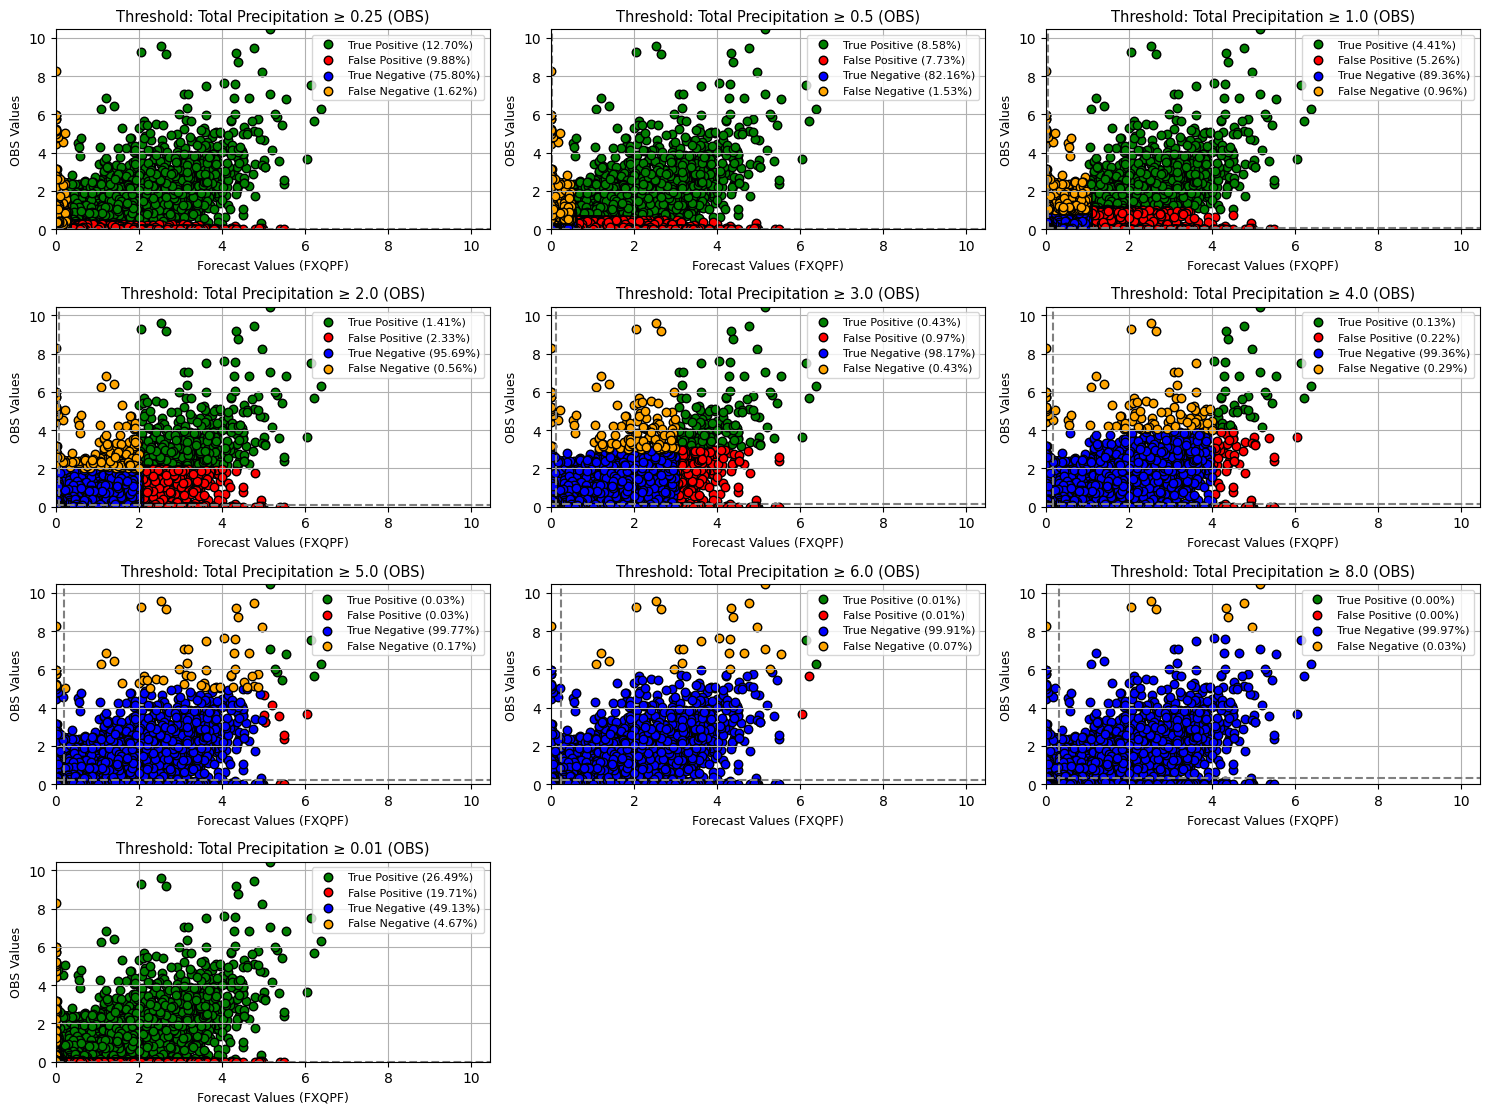

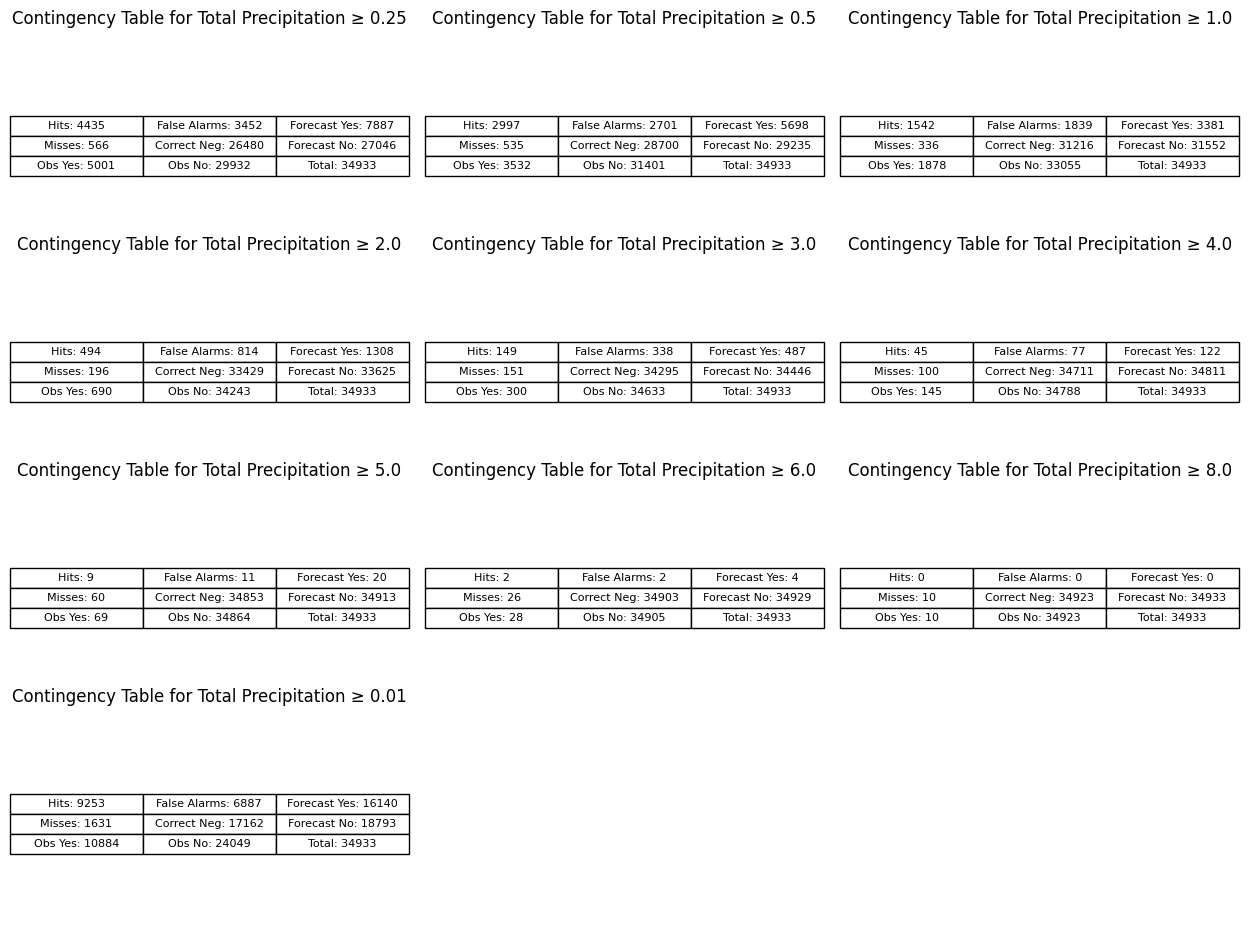

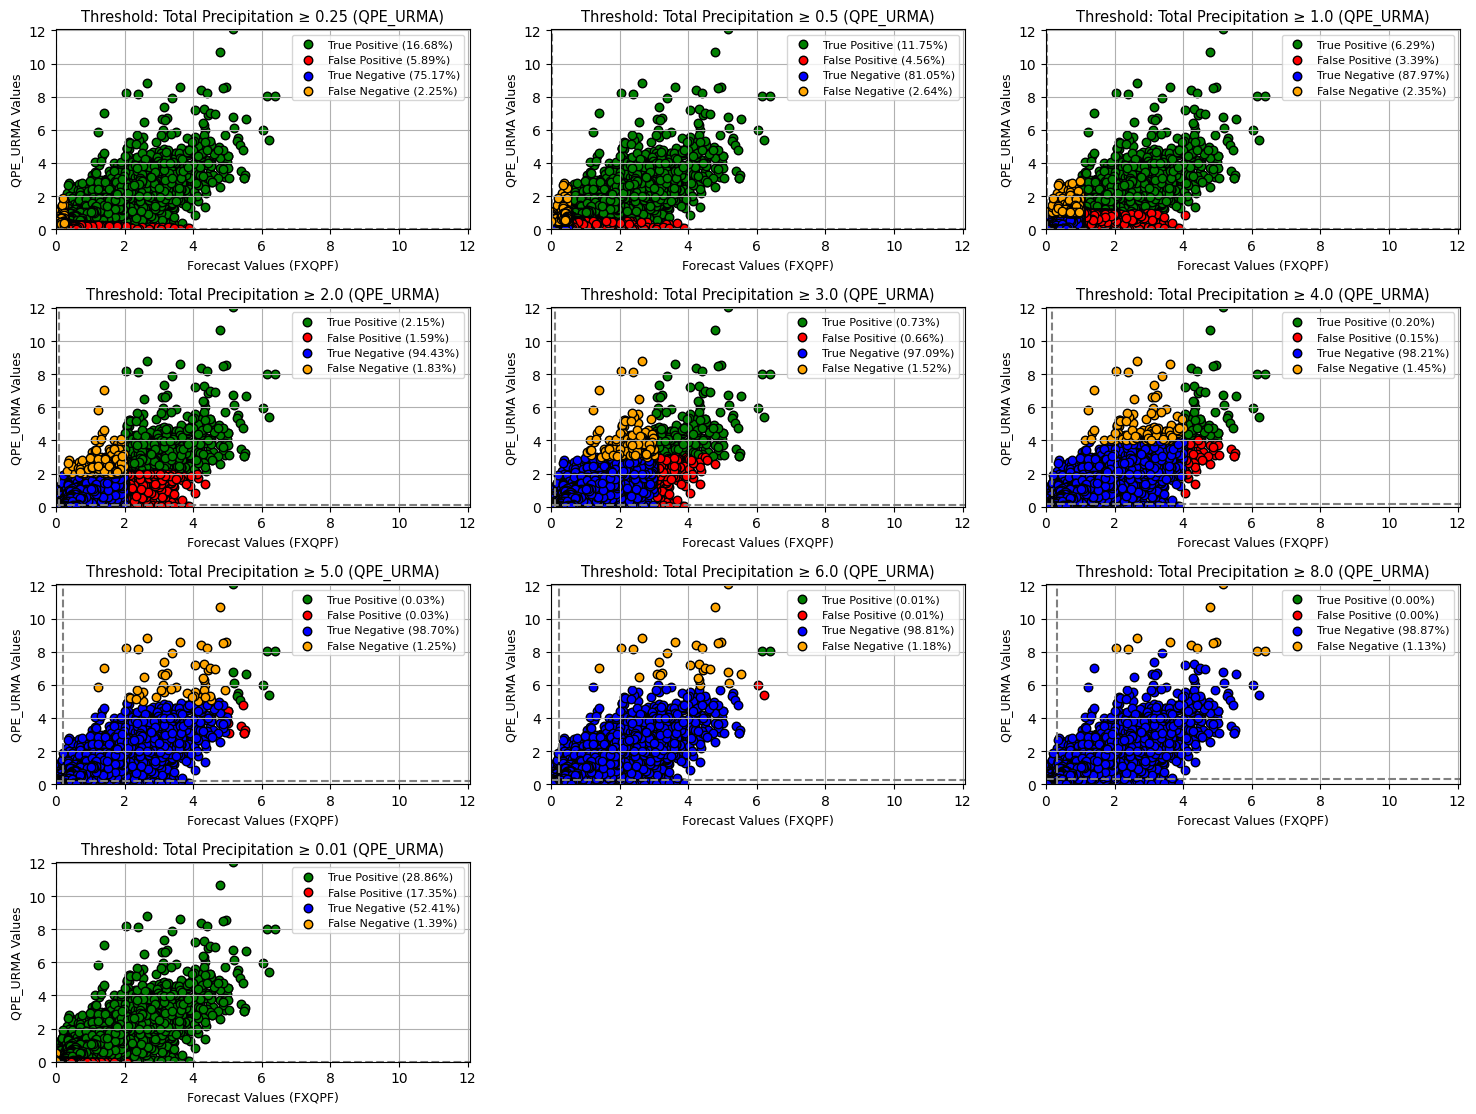

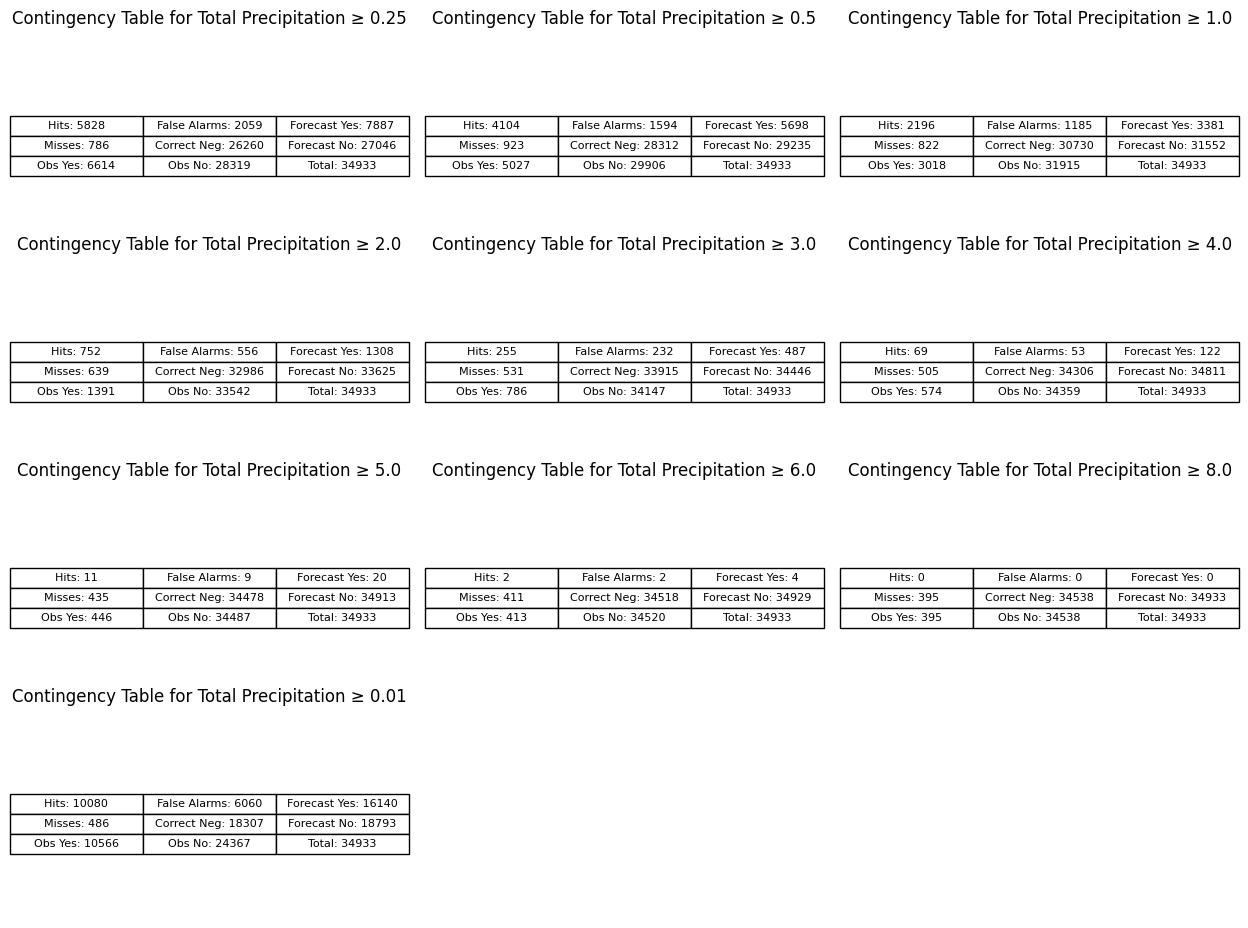




Plots saved and zipped into scatterplots_QPF.zip


In [6]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to classify points and return the contingency counts
def classify_points(row, threshold, value_col, varname, urma_varname, comparison_type):
    fx_value = row[f'FX{varname}']
    obs_value = row[value_col]

    if 'QPF' in varname or 'QPE' in varname:
        fx_value /= 24.5
        obs_value /= 24.5

    if comparison_type == 'le':
        if obs_value <= threshold and fx_value <= threshold:
            return 'True Positive'
        elif obs_value > threshold and fx_value > threshold:
            return 'True Negative'
        elif obs_value > threshold and fx_value <= threshold:
            return 'False Positive'
        else:
            return 'False Negative'
    elif comparison_type == 'ge':
        if obs_value >= threshold and fx_value >= threshold:
            return 'True Positive'
        elif obs_value < threshold and fx_value < threshold:
            return 'True Negative'
        elif obs_value < threshold and fx_value >= threshold:
            return 'False Positive'
        else:
            return 'False Negative'

# Function to decode threshold label
def decode_threshold_label(label):
    parts = label.split('_')
    first_item = {
        'tp': 'Total Precipitation',
        'temp': 'Temperature',
        'maxt': 'Max Temp',
        'tmax': 'Max Temp',
        'mint': 'Min Temp',
        'tmin': 'Min Temp'
    }.get(parts[0], parts[0])

    second_item = {
        'ge': '\u2265',  # greater than or equal to symbol
        'le': '\u2264'   # less than or equal to symbol
    }.get(parts[1], parts[1])

    third_item = parts[2].replace('m', '-').replace('p', '.')

    return f'{first_item} {second_item} {third_item}'

# Define colors for each classification
colors = {
    'True Positive': 'green',
    'False Positive': 'red',
    'True Negative': 'blue',
    'False Negative': 'orange'
}

# Function to plot the contingency table
def plot_contingency_table(ax, contingency_table, threshold_label):
    ax.axis('tight')
    ax.axis('off')
    table_data = [
        ['Hits', 'False Alarms', 'Forecast Yes'],
        ['Misses', 'Correct Negatives', 'Forecast No'],
        ['Observed Yes', 'Observed No', 'Total']
    ]
    table_data[0][0] = f"Hits: {contingency_table['Hits']}"
    table_data[0][1] = f"False Alarms: {contingency_table['False Alarms']}"
    table_data[0][2] = f"Forecast Yes: {contingency_table['Forecast Yes']}"
    table_data[1][0] = f"Misses: {contingency_table['Misses']}"
    table_data[1][1] = f"Correct Neg: {contingency_table['Correct Negatives']}"
    table_data[1][2] = f"Forecast No: {contingency_table['Forecast No']}"
    table_data[2][0] = f"Obs Yes: {contingency_table['Observed Yes']}"
    table_data[2][1] = f"Obs No: {contingency_table['Observed No']}"
    table_data[2][2] = f"Total: {contingency_table['Total']}"

    table = ax.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)
    ax.set_title(f'Contingency Table for {threshold_label}', pad=20)

# Function to generate and save plots and contingency tables
def generate_plots_and_contingency_tables(df, thresholds, value_col, varname, urma_varname, output_dir, display_inline):
    # Determine the maximum value for scaling
    max_value = max(df[f'FX{varname}'].max(), df[value_col].max())
    if 'QPF' in varname or 'QPE' in varname:
        max_value /= 24.5

    num_thresholds = len(thresholds)
    num_cols = 3
    fig, axes = plt.subplots(nrows=(num_thresholds + num_cols - 1) // num_cols, ncols=num_cols, figsize=(15, 11.25))  # 25% smaller
    scatter_axes = axes.flatten()

    plot_index = 0
    contingency_tables = []

    for label, threshold in thresholds.items():
        comparison_type = 'le' if 'le' in label else 'ge'
        df_temp = df.copy()
        df_temp['classification'] = df_temp.apply(classify_points, axis=1, threshold=threshold, value_col=value_col, varname=varname, urma_varname=urma_varname, comparison_type=comparison_type)

        # Calculate the percentage of each classification
        total_points = len(df_temp)
        classification_counts = df_temp['classification'].value_counts()
        classification_percentages = (classification_counts / total_points) * 100

        # Check if more than one category is equal to 0%
        if (classification_percentages == 0).sum() > 1:
            continue

        # Scatter plot
        for classification, color in colors.items():
            subset = df_temp[df_temp['classification'] == classification]
            percentage = classification_percentages[classification] if classification in classification_percentages else 0
            fx_values = subset[f'FX{varname}'] / 24.5 if "QPF" in varname or "QPE" in varname else subset[f'FX{varname}']
            obs_values = subset[value_col] / 24.5 if "QPF" in varname or "QPE" in varname else subset[value_col]
            scatter_axes[plot_index].scatter(fx_values, obs_values, c=color, label=f'{classification} ({percentage:.2f}%)', s=37.5, edgecolor='black')  # 25% smaller

        threshold_scaled = threshold / 24.5 if "QPF" in varname or "QPE" in varname else threshold
        scatter_axes[plot_index].axhline(threshold_scaled, color='gray', linestyle='--', linewidth=1.5)  # 25% smaller
        scatter_axes[plot_index].axvline(threshold_scaled, color='gray', linestyle='--', linewidth=1.5)  # 25% smaller
        scatter_axes[plot_index].set_xlim(0, max_value)
        scatter_axes[plot_index].set_ylim(0, max_value)
        scatter_axes[plot_index].set_xlabel(f'Forecast Values (FX{varname})', fontsize=9)  # 25% smaller
        scatter_axes[plot_index].set_ylabel(f'{value_col} Values', fontsize=9)  # 25% smaller
        decoded_label = decode_threshold_label(label)
        scatter_axes[plot_index].set_title(f'Threshold: {decoded_label} ({value_col})', fontsize=10.5)  # 25% smaller
        scatter_axes[plot_index].legend(fontsize=8)  # 25% smaller
        scatter_axes[plot_index].grid(True)

        # Create contingency table
        hits = classification_counts.get('True Positive', 0)
        false_alarms = classification_counts.get('False Positive', 0)
        misses = classification_counts.get('False Negative', 0)
        correct_negatives = classification_counts.get('True Negative', 0)
        forecast_yes = hits + false_alarms
        forecast_no = misses + correct_negatives
        observed_yes = hits + misses
        observed_no = false_alarms + correct_negatives
        total = observed_yes + observed_no

        contingency_table = {
            'Hits': hits,
            'False Alarms': false_alarms,
            'Misses': misses,
            'Correct Negatives': correct_negatives,
            'Forecast Yes': forecast_yes,
            'Forecast No': forecast_no,
            'Observed Yes': observed_yes,
            'Observed No': observed_no,
            'Total': total
        }

        contingency_tables.append((contingency_table, decoded_label))

        plot_index += 1

    # Hide unused subplots
    for idx in range(plot_index, len(scatter_axes)):
        fig.delaxes(scatter_axes[idx])

    # Adjust layout and save the final plot
    plt.tight_layout()
    plot_filename = os.path.join(output_dir, f'scatter_{value_col}_{varname}.png')
    plt.savefig(plot_filename)

    if display_inline:
        plt.show()
        print('\n\n')

    plt.close(fig)

    # Plot contingency tables after scatter plots
    fig, axes = plt.subplots(nrows=(num_thresholds + num_cols - 1) // num_cols, ncols=num_cols, figsize=(15, 11.25))  # 25% smaller
    table_axes = axes.flatten()

    for i, (contingency_table, decoded_label) in enumerate(contingency_tables):
        plot_contingency_table(table_axes[i], contingency_table, decoded_label)

    # Hide unused subplots
    for idx in range(len(contingency_tables), len(table_axes)):
        fig.delaxes(table_axes[idx])

    # Adjust layout and save the final plot with some space between subplots
    plt.subplots_adjust(wspace=0.25)
    plot_filename = os.path.join(output_dir, f'contingency_tables_{value_col}_{varname}.png')
    plt.savefig(plot_filename)

    if display_inline:
        plt.show()
        print('\n\n')

    plt.close(fig)

# Function to zip saved plots
def zip_plots(output_dir, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, _, files in os.walk(output_dir):
            for file in files:
                if file.endswith('.png'):
                    zipf.write(os.path.join(root, file), arcname=file)

if contingency_plots:
    output_dir = 'scatterplots'
    os.makedirs(output_dir, exist_ok=True)

    # Generate plots and contingency tables for OBS
    generate_plots_and_contingency_tables(df, thresholds, 'OBS', varname, urma_varname, output_dir, display_inline)

    # Generate plots and contingency tables for MINT_URMA
    generate_plots_and_contingency_tables(df, thresholds, f'{urma_varname}_URMA', varname, urma_varname, output_dir, display_inline)

    # Zip the plots
    zip_filename = f'scatterplots_{varname}.zip'
    zip_plots(output_dir, zip_filename)
    print(f'Plots saved and zipped into {zip_filename}')

In [14]:
# Create a new DataFrame to store boolean values for each threshold
df_temp = pd.DataFrame()

# Create boolean columns for each threshold based on FXMINT, OBS, and MINT_URMA
for threshold, value in thresholds.items():
    if 'le' in threshold:
        df_temp[threshold + f'_FX{varname}'] = df[f'FX{varname}'] <= value
        df_temp[threshold + '_OBS'] = df['OBS'] <= value
        df_temp[threshold + f'_{urma_varname}_URMA'] = df[f'{urma_varname}_URMA'] <= value
    elif 'ge' in threshold:
        df_temp[threshold + f'_FX{varname}'] = df[f'FX{varname}'] >= value
        df_temp[threshold + '_OBS'] = df['OBS'] >= value
        df_temp[threshold + f'_{urma_varname}_URMA'] = df[f'{urma_varname}_URMA'] >= value

# Convert probability columns from percentage to decimal
for threshold in thresholds.keys():
    df_temp[threshold] = df[threshold] / 100

# Function to create a contingency table and calculate scores
def create_contingency_table_and_scores(df_temp, threshold, value_col, varname):
    fx_varname = f'_FX{varname}'
    a = ((df_temp[threshold + fx_varname] == True) & (df_temp[threshold + '_' + value_col] == True)).sum()  # True Positive (Hit)
    b = ((df_temp[threshold + fx_varname] == True) & (df_temp[threshold + '_' + value_col] == False)).sum()  # False Positive (False Alarm)
    c = ((df_temp[threshold + fx_varname] == False) & (df_temp[threshold + '_' + value_col] == True)).sum()  # False Negative (Miss)
    d = ((df_temp[threshold + fx_varname] == False) & (df_temp[threshold + '_' + value_col] == False)).sum()  # True Negative (Correct Rejection)

    # Calculate scores
    pod = a / (a + c) if (a + c) > 0 else 0  # Probability of Detection
    far = b / (a + b) if (a + b) > 0 else 0  # False Alarm Ratio
    pofd = b / (b + d) if (b + d) > 0 else 0  # Probability of False Detection
    csi = a / (a + b + c) if (a + b + c) > 0 else 0  # Critical Success Index
    pc = (a + d) / (a + b + c + d) if (a + b + c + d) > 0 else 0  # Percent Correct
    hss = 2 * (a * d - b * c) / ((a + c) * (c + d) + (a + b) * (b + d)) if ((a + c) * (c + d) + (a + b) * (b + d)) > 0 else 0

    # Set scores between 0.99 and 1, and 0.0 and 0.01 to NaN
    scores_dict = {'POD': pod, 'FAR': far, 'POFD': pofd, 'CSI': csi, 'PC': pc, 'HSS': hss}
    for key in scores_dict:
        if 0.999 <= scores_dict[key] <= 1 or 0.0 <= scores_dict[key] <= 0.001:
            scores_dict[key] = np.nan

    return scores_dict

# Function to calculate Brier Score and Brier Skill Score
def calculate_brier_scores(df_temp, threshold, value_col):
    # Calculate Brier Score (BS)
    bs = np.mean((df_temp[threshold] - df_temp[threshold + '_' + value_col]) ** 2)

    # Calculate reference Brier Score (BS_ref, using climatology)
    climatology = np.mean(df_temp[threshold + '_' + value_col])
    bs_ref = np.mean((climatology - df_temp[threshold + '_' + value_col]) ** 2)

    # Calculate Brier Skill Score (BSS)
    bss = 1 - bs / bs_ref if bs_ref != 0 else np.nan

    # Set scores between 0.99 and 1, and 0.0 and 0.01 to NaN
    scores_dict = {'BS': bs, 'BSS': bss}

    return scores_dict

# Function to calculate ROC AUC score
def calculate_roc_auc(df_temp, threshold, value_col):
    try:
        true_labels = df_temp[threshold + '_' + value_col]
        predicted_probs = df_temp[threshold]

        # Ensure true labels are binary
        if set(true_labels) <= {0, 1}:
            auc = roc_auc_score(true_labels, predicted_probs)
        else:
            auc = np.nan
    except ValueError:
        auc = np.nan
    return {'AUC': auc}

# Calculate contingency scores, Brier scores, and ROC AUC scores separately for OBS and MINT_URMA
contingency_scores_obs = {}
brier_scores_obs = {}
roc_auc_scores_obs = {}

contingency_scores_mint_urma = {}
brier_scores_mint_urma = {}
roc_auc_scores_mint_urma = {}

for threshold in thresholds.keys():
    contingency_scores_obs[threshold] = create_contingency_table_and_scores(df_temp, threshold, 'OBS', varname)
    brier_scores_obs[threshold] = calculate_brier_scores(df_temp, threshold, 'OBS')
    roc_auc_scores_obs[threshold] = calculate_roc_auc(df_temp, threshold, 'OBS')

    contingency_scores_mint_urma[threshold] = create_contingency_table_and_scores(df_temp, threshold, f'{urma_varname}_URMA', varname)
    brier_scores_mint_urma[threshold] = calculate_brier_scores(df_temp, threshold, f'{urma_varname}_URMA')
    roc_auc_scores_mint_urma[threshold] = calculate_roc_auc(df_temp, threshold, f'{urma_varname}_URMA')

# Combine all scores into one DataFrame
combined_scores_obs = {}
combined_scores_mint_urma = {}

for threshold in thresholds.keys():
    combined_scores_obs[threshold] = {**contingency_scores_obs[threshold], **brier_scores_obs[threshold], **roc_auc_scores_obs[threshold]}
    combined_scores_mint_urma[threshold] = {**contingency_scores_mint_urma[threshold], **brier_scores_mint_urma[threshold], **roc_auc_scores_mint_urma[threshold]}

combined_scores_df_obs = pd.DataFrame(combined_scores_obs).T
combined_scores_df_mint_urma = pd.DataFrame(combined_scores_mint_urma).T

# Combine both DataFrames into a single DataFrame with multi-level columns
combined_scores_df = pd.concat([combined_scores_df_obs, combined_scores_df_mint_urma], axis=1, keys=['OBS', f'{urma_varname}_URMA'])

combined_scores_df.to_csv('reliability_skill_scores.csv')

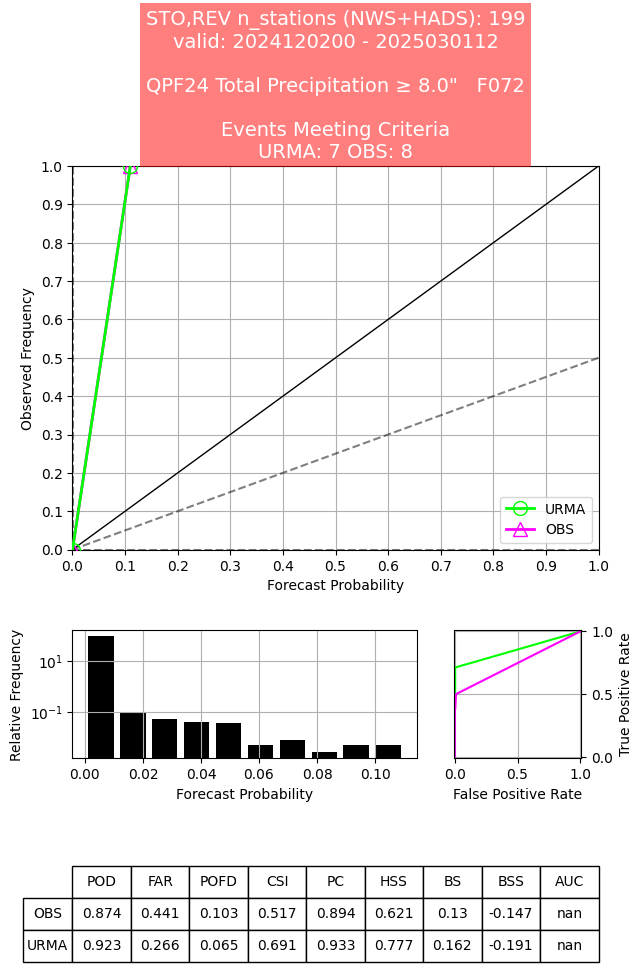

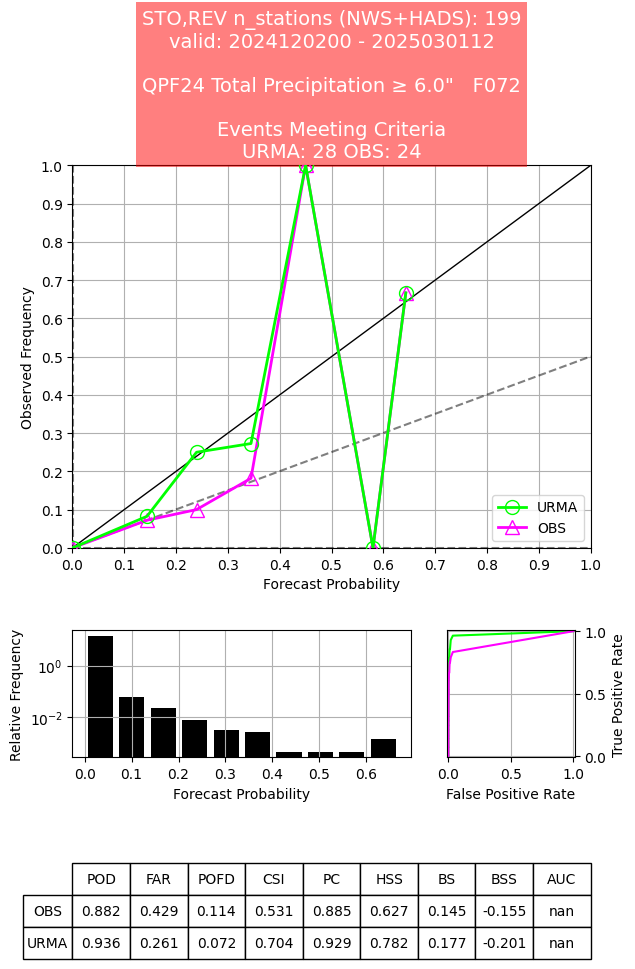

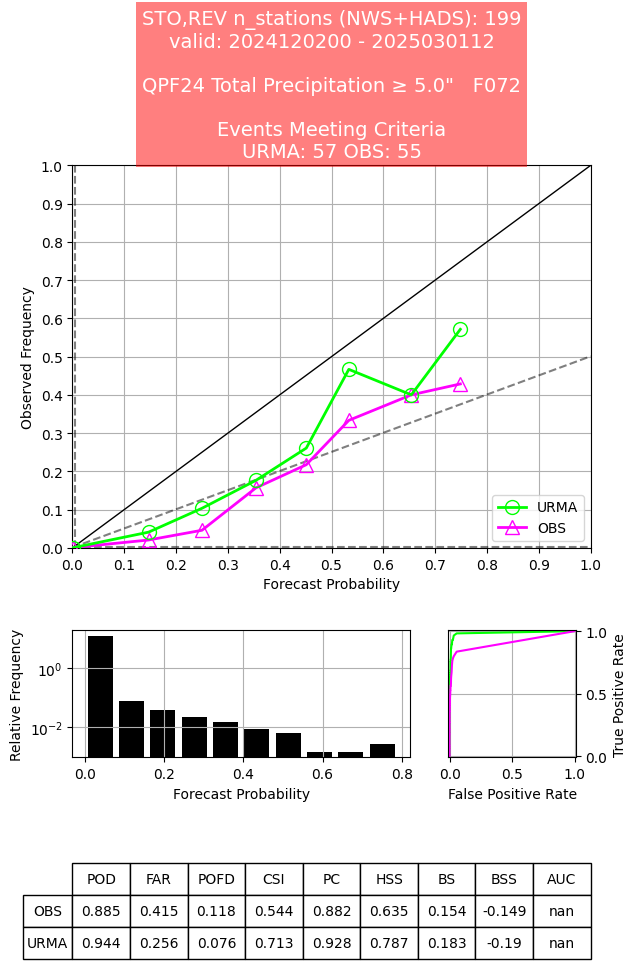

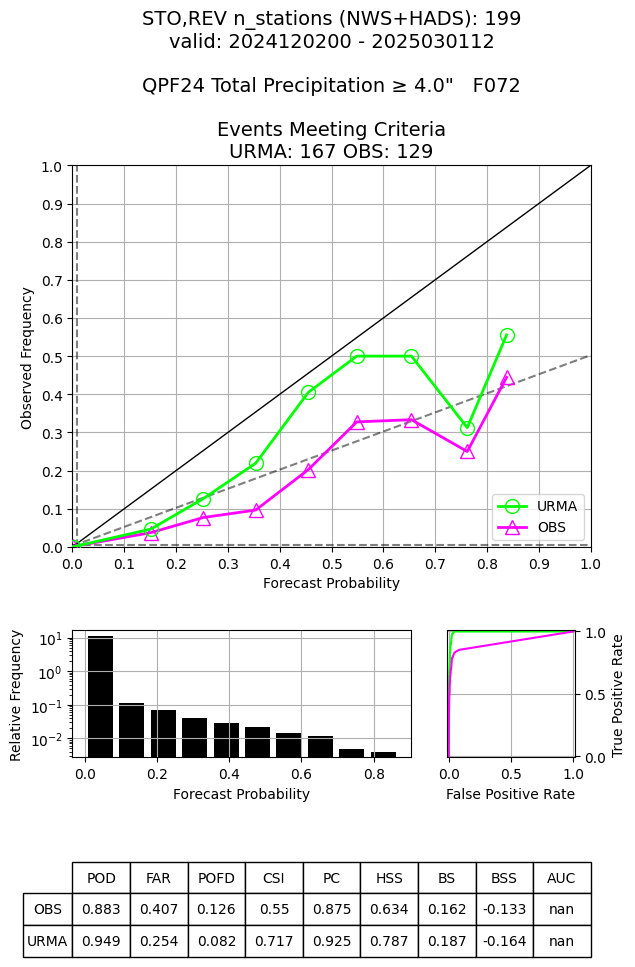

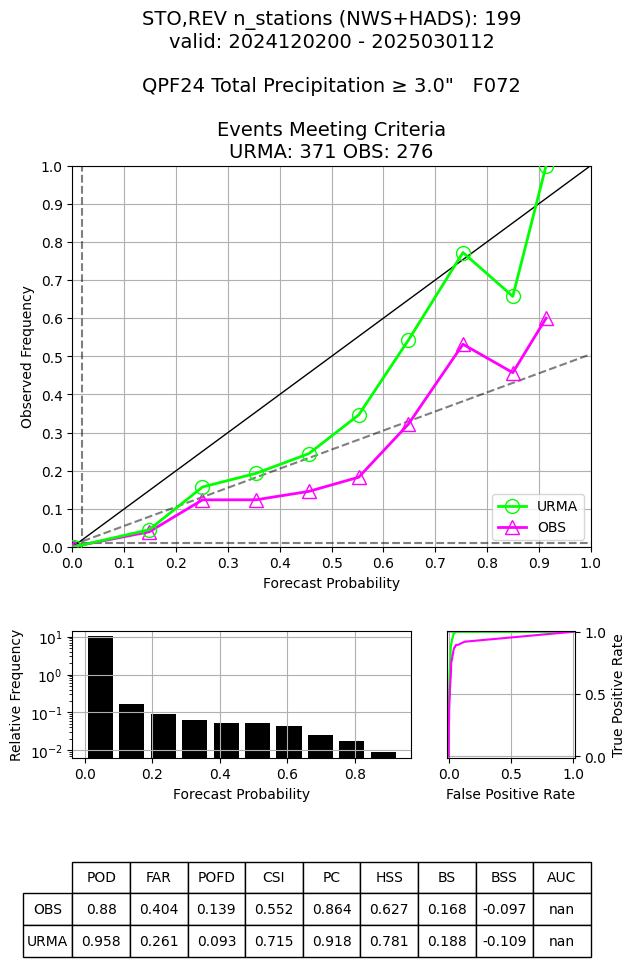

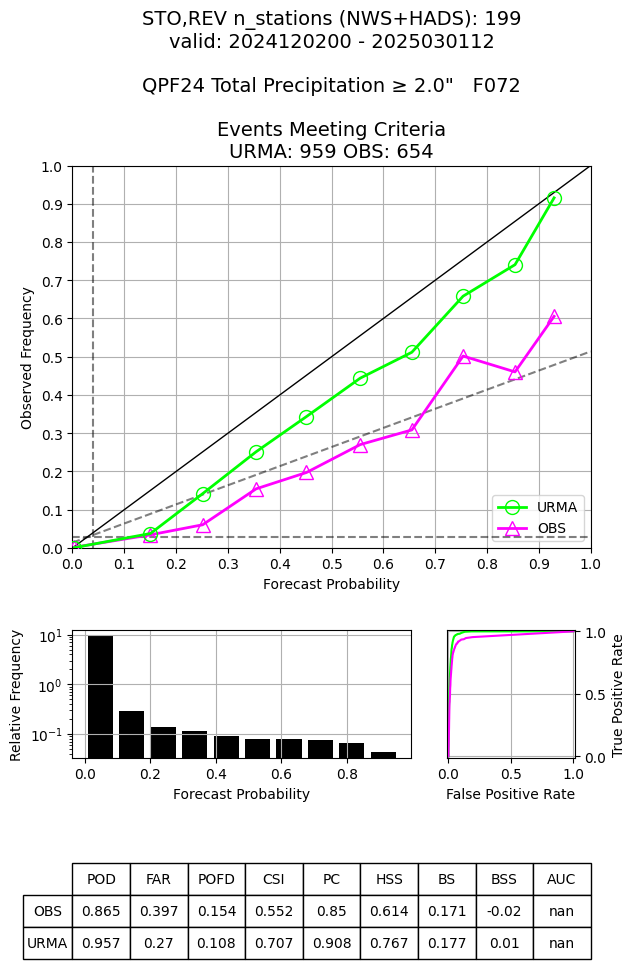

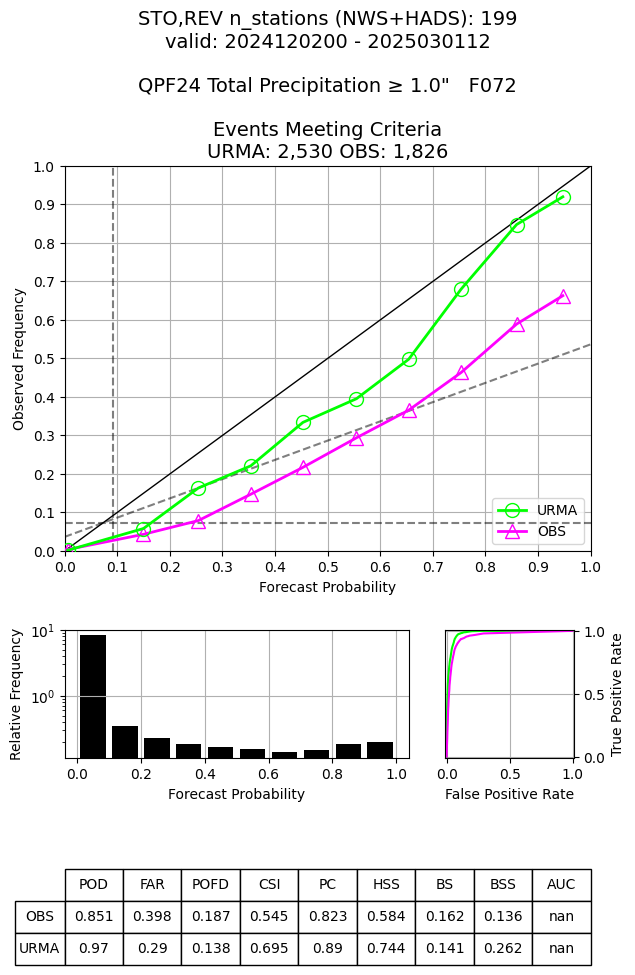

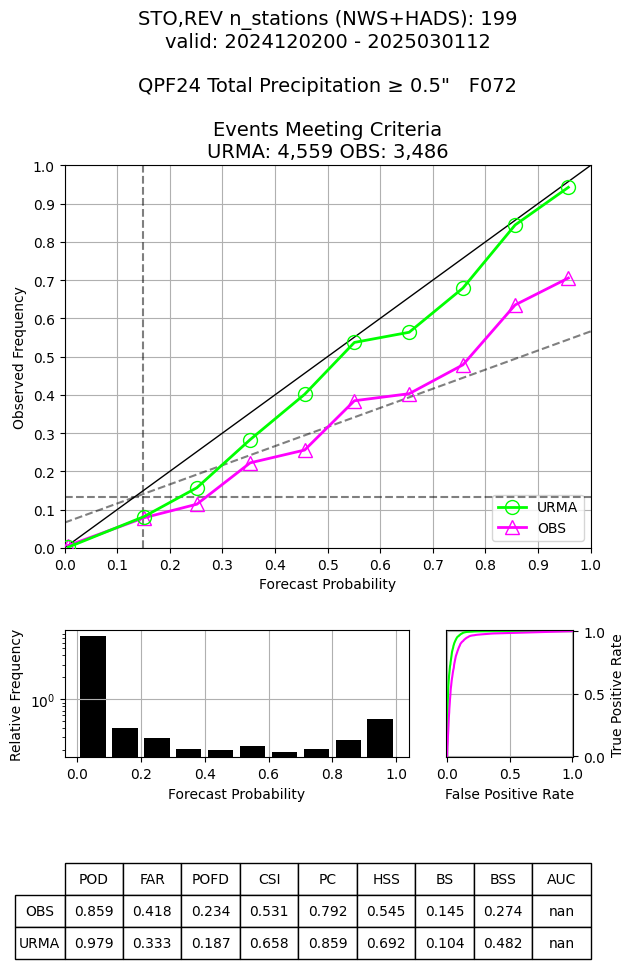

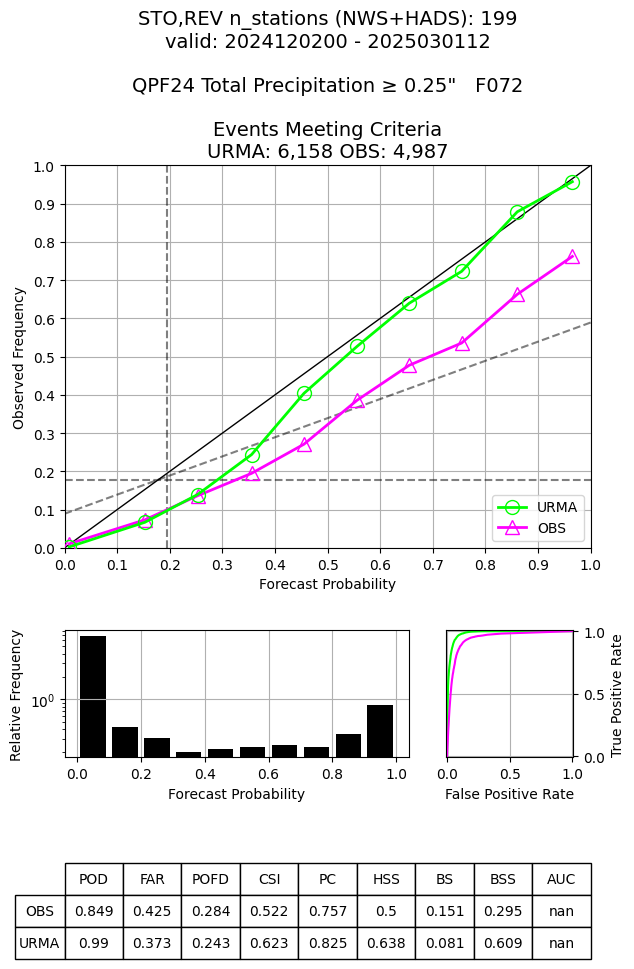

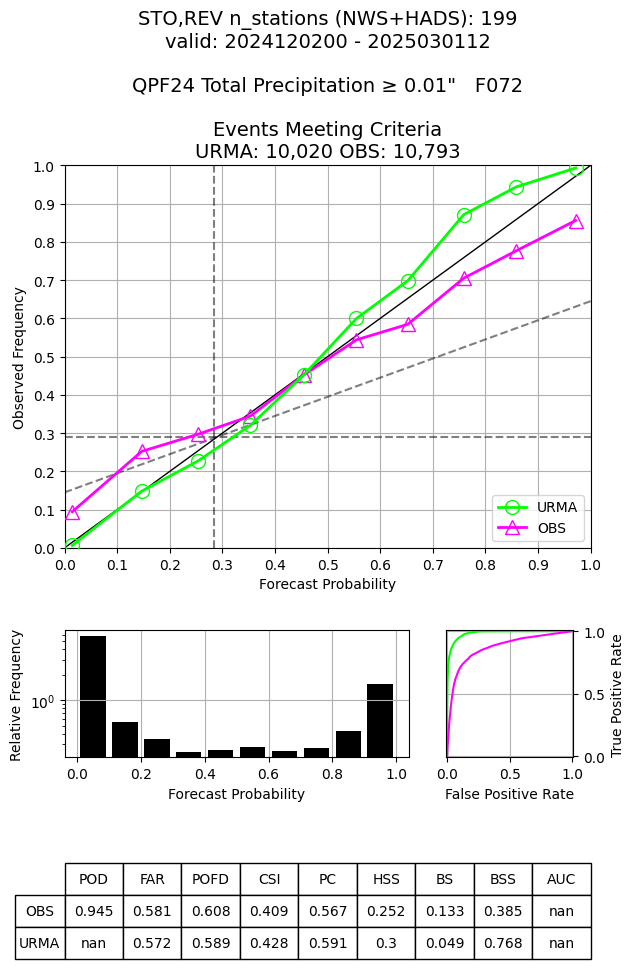

In [10]:
element = element.lower()
C1, C2 = 'Lime', 'Magenta'

df = df.dropna(how='any')
df.index.get_level_values(0).unique()

keylist = [k for k in df.columns if (('ge' in k) or ('le' in k))]

reliability_dir = 'reliability'
os.makedirs(reliability_dir, exist_ok=True)

ziplist = []
for k in sorted(keylist)[::-1]:

    fig = plt.figure(constrained_layout=True, figsize=(6, 8))
    gs = fig.add_gridspec(nrows=4, ncols=3, left=0.05, right=0.5,
                            hspace=-0.05, wspace=0.05)

    ax1 = fig.add_subplot(gs[:-1, :])
    ax2 = fig.add_subplot(gs[-1, :-1])
    ax3 = fig.add_subplot(gs[-1, -1])

    thresh_text = k
    thresh = float(k.split('_')[-1].replace('p', '.').replace('m', '-'))
    thresh = thresh*25.4 if element == 'qpf' else thresh

    # print(thresh_text)

    if 'ge' in thresh_text:
        y_test_ob = np.where(df['OBS'] >=  thresh, 1, 0) #ge vs gt
        y_test = np.where(df[f'{urma_varname}_URMA'] >= thresh, 1, 0)

    elif 'le' in thresh_text:
        y_test_ob = np.where(df['OBS'] <=  thresh, 1, 0) #le vs lt
        y_test = np.where(df[f'{urma_varname}_URMA'] <= thresh, 1, 0)

    y_prob = df[thresh_text]/100
    y_pred = np.where(df['FX'+varname] >= thresh, 1, 0) #ge vs gt

    x_ref = y_prob.sum()/y_prob.size
    y_ref = y_test.sum()/y_test.size
    y_ref_ob = y_test_ob.sum()/y_test_ob.size

    noskill_x, noskill_y = np.array([(bin, (bin + y_ref)/2)
                                    for bin in np.arange(0, 1.1, .1)]).T

    _, noskill_y_ob = np.array([(bin, (bin + y_ref_ob)/2)
                                for bin in np.arange(0, 1.1, .1)]).T

    # Calibration Curves/Reliability Diagrams
    CalibrationDisplay.from_predictions(y_test, y_prob, n_bins=10, ax=ax1, name='URMA',
                                        ref_line=False, marker='o', markersize=10,
                                        markerfacecolor='none', linewidth=2, color=C1,
                                        zorder=10)

    CalibrationDisplay.from_predictions(y_test_ob, y_prob, n_bins=10, ax=ax1, name='OBS',
                                        ref_line=False, marker='^', markersize=10,
                                        markerfacecolor='none', linewidth=2, color=C2,
                                        zorder=9)

    ax1.plot(noskill_x, noskill_y, linestyle='--', linewidth=1.5, color='black', alpha=0.5, zorder=8)
    # ax1.plot(noskill_x, noskill_y_ob, linestyle='--', color=C2)

    ax1.axhline(y_ref, linestyle='--', linewidth=1.5, color='black', alpha=0.5, zorder=6)
    # ax1.axhline(y_ref_ob, linestyle='--', linewidth=1.5, color=C2, alpha=0.5, zorder=-1)

    ax1.axvline(x_ref, linestyle='--', linewidth=1.5, color='black', alpha=0.5, zorder=6)
    ax1.plot([0, 1], [0, 1], '-', linewidth=1, color='black', alpha=1, zorder=7)

    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    ax1.set_yticks(np.arange(0, 1.1, 0.1))

    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])

    ax1.set_xlabel('Forecast Probability')
    ax1.set_ylabel('Observed Frequency')
    ax1.grid(True)

    # Sharpness Diagram
    ax2.hist(y_prob, bins=10, density=True, rwidth=0.8, log=True, color='black')
    ax2.set_xlabel('Forecast Probability')
    ax2.set_ylabel('Relative Frequency')
    ax2.grid(True)

    # ROC-AUC Curves
    RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax3, name='URMA', color=C1)
    RocCurveDisplay.from_predictions(y_test_ob, y_prob, ax=ax3, name='OBS', color=C2)

    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')

    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    ax3.grid(True)
    ax3.get_legend().remove()

    # Use the data from combined_scores_df to fill the table
    try:
        scores = combined_scores_df.T[thresh_text]
    except:
        pass
    else:
        score_df = pd.DataFrame({
            'Metric': ['POD', 'FAR', 'POFD', 'CSI', 'PC', 'HSS', 'BS', 'BSS', 'AUC'],
            'OBS': scores['OBS'].values,
            'URMA': scores[f'{urma_varname}_URMA'].values
        }).set_index('Metric').T

        table = ax1.table(cellText=score_df.values.round(3),
                        colWidths=[0.1] * len(score_df.columns),
                        rowLabels=score_df.index,
                        colLabels=score_df.columns,
                        cellLoc='center', rowLoc='center',
                        loc='bottom', bbox=[0., -1.075, 1., 0.25])

        # Increase font size for each cell in the table
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        for cell in table.get_celld().values():
            cell.set_fontsize(10)

    # Title/Labels
    n_urma = y_test.sum()
    n_ob = y_test_ob.sum()
    n_sites = df.index.get_level_values(1).unique().size

    locname = (cwa_selection if
        ((region_selection == 'CWA') or (region_selection == 'RFC'))
        else region_selection)

    all_dates = df.index.get_level_values(0).unique()
    label_start = all_dates[0].strftime('%Y%m%d%H')
    label_end = all_dates[-1].strftime('%Y%m%d%H')

    suptitle = (f'{locname} n_stations ({network_selection}): {n_sites}\n'+\
                f'valid: {label_start} - {label_end}')

    reformat = {'tp':'Total Precipitation', 'MAXT':'Max Temp', 'tmin':'Min Temp',
            'ge':'≥', 'le':'≤', 'p':'.', 'm':'-', '_':' ', 'temp':''}

    thresh_text_raw = thresh_text
    thresh_text = thresh_text.split('_')
    for k in reformat.keys():
        thresh_text[2] = thresh_text[2].replace(k, reformat[k])

    thresh_text = ' '.join([
        thresh_text[0].replace(thresh_text[0], reformat[thresh_text[0]]),
        thresh_text[1].replace(thresh_text[1], reformat[thresh_text[1]]),
        thresh_text[2]])

    if element == 'qpf':
        title_text = suptitle + '\n'*2 +\
                f'{varname}{interval_selection:02d} {thresh_text}"   F{lead_days_selection*24:-03d}' +\
                    f'\n\nEvents Meeting Criteria\nURMA: {n_urma:,d} OBS: {n_ob:,d}'
    elif ((element == 'maxt') or (element == 'mint')):
        title_text = suptitle + '\n'*2 +\
                f'{varname} {thresh_text}F   F{lead_days_selection*24:-03d}\n\nEvents Meeting Criteria\nURMA: {n_urma:,d} OBS: {n_ob:,d}'

    if n_urma < 100 or n_ob < 100:
        title = ax1.set_title(title_text, fontsize=14)
        title.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='none'))
        title.set_color('white')
    else:
        ax1.set_title(title_text, fontsize=14)

    if varname == 'QPF':
        plot_fname = (f'{locname}_{network_selection.replace("+","-")}'
                    f'_{label_start}-{label_end}_{varname}{interval_selection:02d}'
                    f'_{thresh_text_raw}.reliability.png')
    else:
        plot_fname = (f'{locname}_{network_selection.replace("+","-")}'
                f'_{label_start}-{label_end}_{varname}'
                f'_{thresh_text_raw}.reliability.png')

    plot_fname = os.path.join(reliability_dir, plot_fname)
    # print(f'Plotting/Saving {plot_fname}')

    if display_inline:
        plt.show()
    else:
        plt.savefig(plot_fname)
        ziplist.append(plot_fname)

    plt.close(fig)

if not display_inline:
    def zip_files(files, zip_name):
        with zipfile.ZipFile(zip_name, 'w') as zipf:
            for file in files:
                zipf.write(file, os.path.basename(file))

    zip_name = os.path.join(reliability_dir, '_'.join(plot_fname.split('_')[:-3])+'.zip')
    zip_files(ziplist, zip_name)

    print('Starting download... Manually download zipfile from left sidebar if unsuccessful')
    files.download(zip_name)